In [434]:
import numpy as np
import pandas as pd
import datetime
from scipy import signal

import matplotlib.pyplot as plt

# read, extract, resampled, sliced

In [435]:
def standardize_sensor_raw_info(path_csv_sensor, data_col_names):
    
    sensor_df = pd.read_csv(path_csv_sensor, names=data_col_names)
    unix_time = sensor_df.iloc[0,0]
    
    sampling_frequency = sensor_df.iloc[1,0]
    
    sensor_df_sliced = sensor_df.iloc[2 :, :]
    
    sensor_df_sliced_copy = sensor_df_sliced.copy()
    
    sensor_df_sliced_copy = sensor_df_sliced_copy.reset_index(drop=True)
    
    sampling_time = 1/sampling_frequency
    
    timestamps = unix_time + (sensor_df_sliced_copy.index)*sampling_time
    
    sensor_df_sliced_copy['timestamps'] = timestamps
    
    sensor_df_sliced_copy['starting_timestamp'] = ''
    
    sensor_df_sliced_copy['starting_timestamp'] = [unix_time]+['']*(len(sensor_df_sliced_copy)-1)
    
    end_time = timestamps[-1]
    sensor_df_sliced_copy['ending_timestamp'] = ''
    sensor_df_sliced_copy['ending_timestamp'] = [end_time]+['']*(len(sensor_df_sliced_copy)-1)
    
    
    sensor_df_sliced_copy['sampling_frequency'] = ''
    
    sensor_df_sliced_copy['sampling_frequency'] =[sampling_frequency]+['']*(len(sensor_df_sliced_copy)-1)
    
    return sensor_df_sliced_copy
    
    

In [436]:
def resample_sensor_data(original_standardize_df,  sensor_cols, new_sampling_frequency):
    
    
    orignal_sampling_frequecy = original_standardize_df["sampling_frequency"][0]
    
    multiplier = new_sampling_frequency/orignal_sampling_frequecy
    
    total_new_samples = multiplier * len(original_standardize_df)
    
    new_df = pd.DataFrame()
    
    
    for sensor_col in sensor_cols:
        
        print(sensor_col)
        
        signal_array=original_standardize_df[sensor_col].values
        
        signal_array_resampled = signal.resample(signal_array, int(total_new_samples))
        
        
        new_df[sensor_col] = signal_array_resampled
        
        
    new_sampling_time = 1/new_sampling_frequency
    
    starting_time = original_standardize_df["starting_timestamp"][0]
    
    timestamps = starting_time + (new_df.index)*new_sampling_time
    
    
    
    new_df['timestamps'] = timestamps
    
    
    new_df['starting_timestamp'] = ''
    new_df['starting_timestamp'] = [starting_time]+['']*(len(new_df)-1)
    
    end_time = timestamps[-1]
    new_df['ending_timestamp'] = ''
    new_df['ending_timestamp'] = [end_time]+['']*(len(new_df)-1)
    
    new_df['sampling_frequency'] = ''
    new_df['sampling_frequency'] =[new_sampling_frequency]+['']*(len(new_df)-1)
    
    
    return new_df
        

In [437]:
def magnitude_acc_sensor(std_acc_df):
    
    magnitude= np.sqrt(std_acc_df.iloc[:,0]**2 + std_acc_df.iloc[:,1]**2 + std_acc_df.iloc[:,2]**2)
    std_acc_df['magnitude'] = magnitude
    return std_acc_df

In [438]:
def normalize_signal (std_df, signal_col):
    
    signal = std_df[signal_col]
    
    mean_signal = np.mean(signal)
    
    mean_sub = signal - mean_signal
    
    scaled_data =  mean_sub/np.max(np.abs(mean_sub))
    
    std_df["mean_norm"] = scaled_data
    
    return std_df
    


# Testing on the data 

### Accelorometer data

In [439]:
acc_sensor_path ="C:/Users/muhammad.saif/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/ACC.csv"
data_col_names = ['x', 'y', 'z']

In [440]:
standardize_acc_df=standardize_sensor_raw_info (acc_sensor_path, data_col_names)
standardize_acc_df= magnitude_acc_sensor(standardize_acc_df)

standardize_acc_df = normalize_signal(standardize_acc_df, 'magnitude')

In [441]:
standardize_acc_df

,x,y,z,timestamps,starting_timestamp,ending_timestamp,sampling_frequency,magnitude,mean_norm
0,24.0,-7.0,58.0,1.695387e+09,1695386909.0,1695390797.90625,32.0,63.158531,0.004212
1,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
2,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
3,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
4,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
...,...,...,...,...,...,...,...,...,...
124441,9.0,14.0,61.0,1.695391e+09,,,,63.229740,0.005065
124442,9.0,14.0,61.0,1.695391e+09,,,,63.229740,0.005065
124443,9.0,14.0,61.0,1.695391e+09,,,,63.229740,0.005065
124444,9.0,15.0,61.0,1.695391e+09,,,,63.458648,0.007810


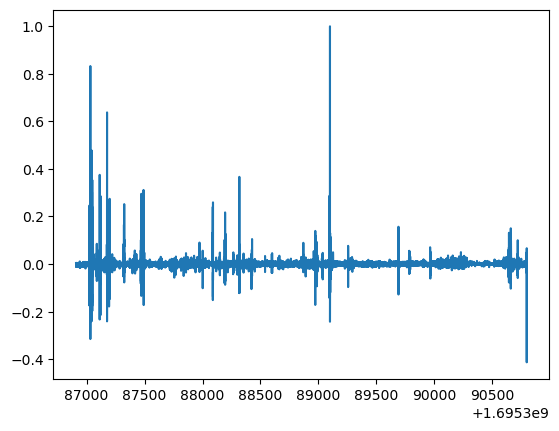

In [442]:
plt.plot(standardize_acc_df["timestamps"],standardize_acc_df["mean_norm"])

### Eda Data

In [412]:
eda_sensor_path ="C:/Users/muhammad.saif/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/EDA.csv"
data_col_names = ['signal']

In [413]:
eda_df_standardize=standardize_sensor_raw_info(eda_sensor_path, data_col_names)
eda_df_standardize["starting_timestamp"][0]

1695386909.0

In [414]:
eda_df_standardize["starting_timestamp"][0] == standardize_acc_df["starting_timestamp"][0]

True

In [444]:
resampled_standardized_eda_df = resample_sensor_data(eda_df_standardize,  ["signal"], 32)

signal


In [445]:
resampled_standardized_eda_df

,signal,timestamps,starting_timestamp,ending_timestamp,sampling_frequency
0,1.637465e-15,1.695387e+09,1695386909.0,1695390796.96875,32
1,-6.030448e-01,1.695387e+09,,,
2,-9.823771e-01,1.695387e+09,,,
3,-1.144831e+00,1.695387e+09,,,
4,-1.115277e+00,1.695387e+09,,,
...,...,...,...,...,...
124411,5.314990e+00,1.695391e+09,,,
124412,4.121475e+00,1.695391e+09,,,
124413,2.929519e+00,1.695391e+09,,,
124414,1.806666e+00,1.695391e+09,,,


In [446]:
resampled_standardized_eda_df = normalize_signal (resampled_standardized_eda_df, "signal")

In [447]:
resampled_standardized_eda_df


,signal,timestamps,starting_timestamp,ending_timestamp,sampling_frequency,mean_norm
0,1.637465e-15,1.695387e+09,1695386909.0,1695390796.96875,32,-0.329204
1,-6.030448e-01,1.695387e+09,,,,-0.407053
2,-9.823771e-01,1.695387e+09,,,,-0.456023
3,-1.144831e+00,1.695387e+09,,,,-0.476994
4,-1.115277e+00,1.695387e+09,,,,-0.473179
...,...,...,...,...,...,...
124411,5.314990e+00,1.695391e+09,,,,0.356929
124412,4.121475e+00,1.695391e+09,,,,0.202854
124413,2.929519e+00,1.695391e+09,,,,0.048979
124414,1.806666e+00,1.695391e+09,,,,-0.095974


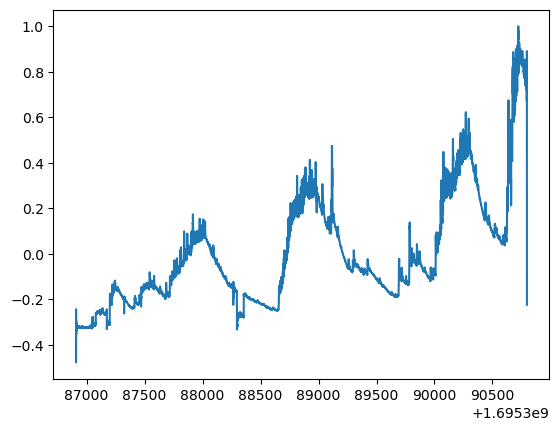

In [448]:
plt.plot(resampled_standardized_eda_df["timestamps"], resampled_standardized_eda_df["mean_norm"])

In [450]:
eda_df_standardize_norm = normalize_signal (eda_df_standardize, "signal")

In [451]:
eda_df_standardize_norm

,signal,timestamps,starting_timestamp,ending_timestamp,sampling_frequency,mean_norm
0,0.000000,1.695387e+09,1695386909.0,1695390796.75,4.0,-0.329462
1,0.024342,1.695387e+09,,,,-0.326317
2,0.052528,1.695387e+09,,,,-0.322676
3,0.055091,1.695387e+09,,,,-0.322344
4,0.055091,1.695387e+09,,,,-0.322344
...,...,...,...,...,...,...
15547,8.408756,1.695391e+09,,,,0.756909
15548,8.397226,1.695391e+09,,,,0.755419
15549,8.380570,1.695391e+09,,,,0.753267
15550,8.354947,1.695391e+09,,,,0.749957


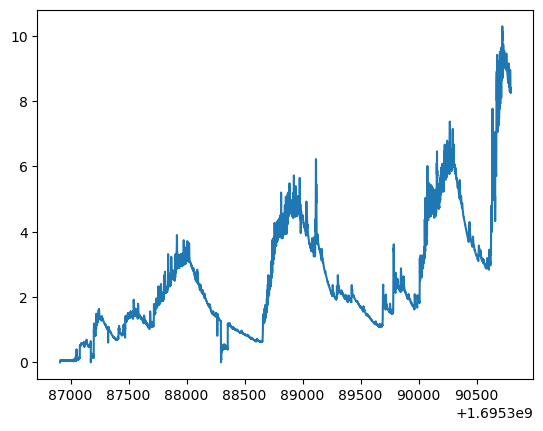

In [453]:
plt.plot(eda_df_standardize_norm["timestamps"], eda_df_standardize_norm["signal"])

### comparing date and time 

In [455]:
dt_obj_eda = datetime.datetime.fromtimestamp(eda_df_standardize_norm["starting_timestamp"][0])

In [456]:
dt_obj

datetime.datetime(2023, 9, 22, 14, 48, 29)

In [ ]:
standardize_acc_df

In [458]:
dt_obj_acc=datetime.datetime.fromtimestamp(standardize_acc_df["starting_timestamp"][0])

In [459]:
dt_obj_acc

datetime.datetime(2023, 9, 22, 14, 48, 29)

In [460]:
hr_sensor_path ="C:/Users/muhammad.saif/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/HR.csv"
data_col_names = ['signal']

In [461]:
hr_df_standardize=standardize_sensor_raw_info(hr_sensor_path, data_col_names)
hr_df_standardize["starting_timestamp"][0]

1695386919.0

In [462]:
hr_df_standardize

,signal,timestamps,starting_timestamp,ending_timestamp,sampling_frequency
0,68.00,1.695387e+09,1695386919.0,1695390797.0,1.0
1,66.50,1.695387e+09,,,
2,66.00,1.695387e+09,,,
3,66.00,1.695387e+09,,,
4,66.40,1.695387e+09,,,
...,...,...,...,...,...
3874,68.62,1.695391e+09,,,
3875,68.50,1.695391e+09,,,
3876,68.35,1.695391e+09,,,
3877,68.18,1.695391e+09,,,


In [471]:
time_stamp_np_array= hr_df_standardize["timestamps"].values

In [472]:
time_stamp_np_array[-1] ==hr_df_standardize["ending_timestamp"][0]

True

In [473]:
resampled_standardized_hr_df = resample_sensor_data(hr_df_standardize,  ["signal"], 32)

signal


In [474]:
resampled_standardized_hr_df

,signal,timestamps,starting_timestamp,ending_timestamp,sampling_frequency
0,68.000000,1.695387e+09,1695386919.0,1695390797.96875,32
1,67.971097,1.695387e+09,,,
2,67.939934,1.695387e+09,,,
3,67.906560,1.695387e+09,,,
4,67.871036,1.695387e+09,,,
...,...,...,...,...,...
124123,68.109741,1.695391e+09,,,
124124,68.092452,1.695391e+09,,,
124125,68.072838,1.695391e+09,,,
124126,68.050889,1.695391e+09,,,


In [475]:
hr_df_standardize_norm = normalize_signal (resampled_standardized_hr_df, "signal")

In [476]:
hr_df_standardize_norm

,signal,timestamps,starting_timestamp,ending_timestamp,sampling_frequency,mean_norm
0,68.000000,1.695387e+09,1695386919.0,1695390797.96875,32,-0.116270
1,67.971097,1.695387e+09,,,,-0.116733
2,67.939934,1.695387e+09,,,,-0.117231
3,67.906560,1.695387e+09,,,,-0.117765
4,67.871036,1.695387e+09,,,,-0.118333
...,...,...,...,...,...,...
124123,68.109741,1.695391e+09,,,,-0.114515
124124,68.092452,1.695391e+09,,,,-0.114792
124125,68.072838,1.695391e+09,,,,-0.115105
124126,68.050889,1.695391e+09,,,,-0.115456


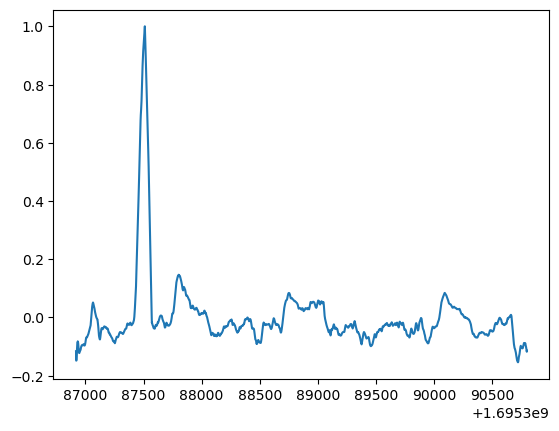

In [477]:
plt.plot(hr_df_standardize_norm["timestamps"],hr_df_standardize_norm["mean_norm"])

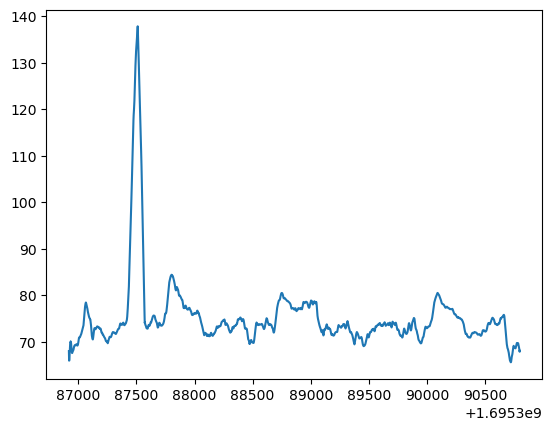

In [478]:
plt.plot(hr_df_standardize_norm["timestamps"],hr_df_standardize_norm["signal"])

In [481]:
starting_timestamp_hr = hr_df_standardize_norm["starting_timestamp"][0]
starting_timestamp_eda = eda_df_standardize_norm["starting_timestamp"][0]

In [482]:
starting_timestamp_hr == starting_timestamp_eda

False